# Coaching Total Pay Analysis
## IST 718 - Lab 1 
### Andrea Brennan 01/22/2022

# OBTAIN
Load baseline packages and set jupyter to return all results in a single cell:

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.stats import uniform  # for training-and-test split
import statsmodels.formula.api as smf  # regression building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import tmin

Read following data sources into dataframe:
* Coaches9.csv - Coach data
* Stadium Capacity.csv - Stadium Capacity data https://www.collegegridirons.com/comparisons-by-capacity/
* College Football Records 2018.csv - Win Loss & Performance data https://www.kaggle.com/jeffgallini/college-football-team-stats-2019?select=cfb18.csv
* GSR.csv - Graduation Rate data https://web3.ncaa.org/aprsearch/gsrsearch

In [ ]:
coach = pd.read_csv('Coaches9.csv')
s = pd.read_csv('Stadium Capacity.csv')
wl = pd.read_csv('College Football Records 2018.csv')
gsr = pd.read_csv('GSR.csv')

## Clean Stadium data
Cleaning all data using Coaches as source of truth for values

Stanardize Conference Names

In [ ]:
s.loc[s.Conference == "Mountain West", "Conference"] = "Mt. West"
s.loc[s.Conference=="CUSA", "Conference"] = "C-USA"
s.loc[s.Conference=="Independent", "Conference"] = "Ind."
s.loc[s.Conference=="Pac 12", "Conference"] = "Pac-12"

In [ ]:
s.head(5)

,Stadium,School,Conference,Capacity,Opened
0,Falcon Stadium,Air Force,Mt. West,"52,237",1962
1,InfoCision Stadium,Akron,MAC,"30,000",2009
2,Bryant Denny Stadium,Alabama,SEC,"101,821",1929
3,Kidd Brewer Stadium,Appalachian State,Sun Belt,"24,150",1962
4,Arizona Stadium,Arizona,Pac-12,"56,037",1928


Drop Opened column

In [ ]:
s = s.drop(['Opened'], axis=1)

In [ ]:
s.head(5)
s.describe()

,Stadium,School,Conference,Capacity
0,Falcon Stadium,Air Force,Mt. West,"52,237"
1,InfoCision Stadium,Akron,MAC,"30,000"
2,Bryant Denny Stadium,Alabama,SEC,"101,821"
3,Kidd Brewer Stadium,Appalachian State,Sun Belt,"24,150"
4,Arizona Stadium,Arizona,Pac-12,"56,037"


,Stadium,School,Conference,Capacity
count,131,131,131,131
unique,124,131,11,116
top,Memorial Stadium,Fresno State,SEC,"30,000"
freq,8,1,14,5


In [ ]:
# coach.reset_index(drop=True)
# s.reset_index(drop=True)
# df.reset_index(drop=True)

In [ ]:
df = coach.merge(s.drop_duplicates(), on=['School', 'Conference'], how='left', indicator=True)
df[df['_merge']=='left_only']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,_merge
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",NaN,NaN,left_only
16,Brigham Young,Ind.,Kalani Sitake,--,--,--,--,$0,--,NaN,NaN,left_only
21,Charlotte,C-USA,Brad Lambert,"$625,000","$625,000","$120,000",$0,$0,"$556,389",NaN,NaN,left_only
50,Liberty,Ind.,Turner Gill,"$947,281","$947,281",--,--,$0,--,NaN,NaN,left_only
58,Massachusetts,Ind.,Mark Whipple,"$500,000","$500,000","$305,000","$20,000",$0,"$300,000",NaN,NaN,left_only
60,Miami (Fla.),ACC,Mark Richt,"$4,058,061","$4,058,061",--,--,$0,--,NaN,NaN,left_only
61,Miami (Ohio),MAC,Chuck Martin,"$524,826","$524,826","$582,110","$12,669",$0,"$522,300",NaN,NaN,left_only
72,Nevada-Las Vegas,Mt. West,Tony Sanchez,"$600,000","$600,000","$260,000",$0,$0,"$950,000",NaN,NaN,left_only
74,New Mexico State,Ind.,Doug Martin,"$419,640","$419,640","$220,000","$20,000",$0,"$1,532,790",NaN,NaN,left_only
76,North Carolina State,ACC,Dave Doeren,"$3,000,000","$3,000,000","$1,350,000","$275,000",$0,"$6,125,000",NaN,NaN,left_only


Clean School names where needed

In [ ]:
s.loc[s.School=="UNC Charlotte", "School"] = "Charlotte"
s.loc[s.School=="UMass", "School"] = "Massachusetts"
s.loc[s.School=="Miami-OH", "School"] = "Miami (Ohio)"
s.loc[s.School=="NC State", "School"] = "North Carolina State"
s.loc[s.School=="USC", "School"] = "Southern California"
s.loc[s.School=="SMU", "School"] = "Southern Methodist"
s.loc[s.School=="Miami", "School"] = "Miami (Fla.)"
s.loc[s.School=="TCU", "School"] = "Texas Christian"
s.loc[s.School=="UAB", "School"] = "Alabama at Birmingham"
s.loc[s.School=="UNLV", "School"] = "Nevada-Las Vegas"
s.loc[s.School=="Southern Miss", "School"] = "Southern Mississippi"
s.loc[s.School=="UTEP", "School"] = "Texas-El Paso"
s.loc[s.School=="UTSA", "School"] = "Texas-San Antonio"
s.loc[s.School=="BYU", "School"] = "Brigham Young"

In [ ]:
s[s['School']=='New Mexico State']

,Stadium,School,Conference,Capacity
71,Aggie Memorial Stadium,New Mexico State,Sun Belt,"30,343"


New Mexico State changed from Independent to Sun Belt and then back to the Independent Conference. Correcting for this:

In [ ]:
s.loc[s.School=="New Mexico State", "Conference"] = "Ind."

In [ ]:
# s['Stadium']=str(s['Stadium'])                                                                                                                                                                                                                             
# s.dtypes
# coach.dtypes

In [ ]:
df = coach.merge(s.drop_duplicates(), on=['School', 'Conference'], how='left', indicator=True)
df[df['_merge']=='left_only']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,_merge
50,Liberty,Ind.,Turner Gill,"$947,281","$947,281",--,--,$0,--,NaN,NaN,left_only


In [ ]:
df.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,_merge
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,"52,237",both
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,"30,000",both
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,"101,821",both
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,"71,594",both
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,"24,150",both


In [ ]:
df['Capacity'] = df['Capacity'].replace({',':''}, regex=True)

# Clean Win Loss Data

In [ ]:
wl.head(5)

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,Def.Plays,Yards.Allowed,Yards.Play.Allowed,Off.TDs.Allowed,Total.TDs.Allowed,Yards.Per.Game.Allowed,First.Down.Rank,First.Down.Runs,First.Down.Passes,First.Down.Penalties,First.Downs,First.Down.Def.Rank,Opp.First.Down.Runs,Opp.First.Down.Passes,Opp.First.Down.Penalties,Opp.First.Downs,X4th.Down.Rank,X4th.Attempts,X4th.Conversions,X4th.Percent,X4rd.Down.Def.Rank,Opp.4th.Conversion,Opp.4th.Attempt,Opponent.4th.Percent,Kickoff.Return.Rank,Kickoffs.Returned,Kickoff.Return.Yards,Kickoff.Return.Touchdowns,Avg.Yard.per.Kickoff.Return,...,Opp.Deflected.Extra.Points,Opp.Feild.Goals.Made,Opp.Safety,Points.Allowed,Avg.Points.per.Game.Allowed,Scoring.Off.Rank,Touchdowns,PAT,X2.Point.Conversions,Defensive.Points,Feild.Goals,Safety,Total.Points,Points.Per.Game,Tackle.for.Loss.Rank,Solo.Tackle.For.Loss,Assist.Tackle.For.Loss,Tackle.for.Loss.Yards,Total.Tackle.For.Loss,Tackle.For.Loss.Per.Game,X3rd.Down.Rank,X3rd.Attempts,X3rd.Conversions,X3rd.Percent,X3rd.Down.Def.Rank,Opp.3rd.Conversion,Opp.3rd.Attempt,Opponent.3rd.Percent,Time.of.Possession.Rank,Time.of.Possession,Average.Time.of.Possession.per.Game,Turnover.Rank,Fumbles.Recovered,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game
0,Air Force (MWC),12,5,7,52,882,4978,5.64,43,414.80,43,732,4331,5.92,40,42,360.90,8,76,121,12,209,8,76,121,12,209,30,24,40,0.60,32,8,18,0.44,11,32,29,550,0,...,0,6,0,309,25.80,55,47,41,3,0,10,2,363,30.30,72,50,38,267,69,5.80,49,169,70,0.41,93,64,153,0.42,4,412:24,34:22,77,7,7,14,10,5,15,-1,-0.08
1,Akron (MAC),12,4,8,126,764,3533,4.62,21,294.40,61,898,4657,5.19,37,41,388.10,60,127,111,18,256,60,127,111,18,256,128,5,17,0.29,51,12,24,0.50,110,18,29,420,0,...,1,13,0,326,27.20,124,26,23,0,0,16,0,227,18.90,38,62,38,345,81,6.80,128,169,49,0.29,44,70,189,0.37,104,337:54,28:09,103,11,10,21,12,14,26,-5,-0.42
2,Alabama (SEC),15,14,1,6,1009,7830,7.76,85,522.00,16,981,4793,4.89,33,35,319.50,53,93,131,29,253,53,93,131,29,253,97,7,15,0.47,36,11,24,0.46,53,41,44,825,0,...,0,9,0,271,18.10,3,92,83,0,0,15,2,684,45.60,26,83,48,395,107,7.10,3,165,86,0.52,24,76,222,0.34,52,454:55,30:19,34,7,14,21,7,8,15,6,0.40
3,Appalachian St. (Sun Belt),13,11,2,37,859,5603,6.52,58,431.00,6,845,3744,4.43,20,21,288.00,7,91,98,19,208,7,91,98,19,208,38,13,22,0.59,1,6,22,0.27,124,31,50,799,0,...,0,18,0,201,15.50,17,64,63,0,0,12,1,485,37.30,43,66,40,309,86,6.60,44,169,71,0.42,14,59,186,0.32,45,397:29,30:34,30,6,17,23,5,12,17,6,0.46
4,Arizona (Pac-12),12,5,7,24,881,5492,6.23,43,457.70,92,904,5184,5.73,51,52,432.00,102,102,146,36,284,102,102,146,36,284,74,9,18,0.50,98,17,28,0.61,72,11,60,231,0,...,0,9,0,391,32.60,42,46,39,0,0,19,2,376,31.30,55,66,20,275,76,6.30,27,181,79,0.44,87,76,185,0.41,100,339:11,28:15,90,8,7,15,9,10,19,-4,-0.33


Drop unused columns

In [ ]:
wl = wl[wl.columns[[0,1,2,3]]]

In [ ]:
wl.head(5)

,Team,Games,Win,Loss
0,Air Force (MWC),12,5,7
1,Akron (MAC),12,4,8
2,Alabama (SEC),15,14,1
3,Appalachian St. (Sun Belt),13,11,2
4,Arizona (Pac-12),12,5,7


In [ ]:
# Split Teams column by delimiter
new = wl['Team'].str.split(' \(',expand=True)

# Create new columns for conference & school
wl["School"]=new[0]
wl["Conference"]=new[1]

# Remove trailing parenthesis
wl['Conference'] = wl['Conference'].str.replace('\)', "")

wl = wl[wl.columns[[4,5,1,2,3]]]

wl.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,School,Conference,Games,Win,Loss
0,Air Force,MWC,12,5,7
1,Akron,MAC,12,4,8
2,Alabama,SEC,15,14,1
3,Appalachian St.,Sun Belt,13,11,2
4,Arizona,Pac-12,12,5,7


Clean up Conference Values

In [ ]:
set(wl['Conference'])

{'AAC',
 'ACC',
 'Big 12',
 'Big Ten',
 'C-USA',
 'FBS Independent',
 'FL',
 'MAC',
 'MWC',
 'OH',
 'Pac-12',
 'SEC',
 'Sun Belt'}

In [ ]:
wl.loc[wl.Conference=="MWC", "Conference"] = "Mt. West"
wl.loc[wl.Conference=="FBS Independent", "Conference"] = "Ind."
wl.loc[wl.Conference=="FL", "Conference"] = "ACC"
wl.loc[wl.Conference=="OH", "Conference"] = "MAC"

In [ ]:
df = df.drop(['_merge'], axis=1)
df.reset_index(drop=True)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,30000
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,101821
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150
...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,"$3,605,000","$3,617,500","$1,000,000","$90,000",$0,"$7,150,000",Mountaineer Field,60000
125,Western Kentucky,C-USA,Mike Sanford Jr.,"$800,000","$805,850","$400,000",$0,$0,"$1,200,000",LT Smith Stadium,22113
126,Western Michigan,MAC,Tim Lester,"$800,000","$800,000","$346,500","$39,250",$0,"$800,000",Waldo Stadium,30200
127,Wisconsin,Big Ten,Paul Chryst,"$3,750,000","$3,750,000",--,"$290,000",$0,"$6,000,000",Camp Randall Stadium,80321


In [ ]:
df1 = df.merge(wl.drop_duplicates(), on=['School', 'Conference'], how='left', indicator=True)
df1[(df1['_merge']=='left_only')]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,_merge
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594,nan,nan,nan,left_only
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150,nan,nan,nan,left_only
6,Arizona State,Pac-12,Herm Edwards,"$2,000,000","$2,000,000","$3,010,000",--,$0,"$8,166,667",Sun Devil Stadium,56232,nan,nan,nan,left_only
8,Arkansas State,Sun Belt,Blake Anderson,"$825,000","$825,000","$185,000","$25,000",$0,"$300,000",Centennial Bank Stadium,30964,nan,nan,nan,left_only
9,Army,Ind.,Jeff Monken,932521,932521,--,--,$0,--,Michie Stadium,38000,nan,nan,nan,left_only
11,Ball State,MAC,Mike Neu,"$435,689","$435,689","$380,000","$30,000",$0,"$980,300",Scheumann Stadium,22500,nan,nan,nan,left_only
13,Boise State,Mt. West,Bryan Harsin,"$1,650,010","$1,650,010","$475,000","$145,000",$0,"$7,784,038",Albertsons Stadium,37000,nan,nan,nan,left_only
16,Brigham Young,Ind.,Kalani Sitake,--,--,--,--,$0,--,LaVell Edwards Stadium,63725,nan,nan,nan,left_only
19,Central Florida,AAC,Josh Heupel,"$1,700,000","$1,700,000","$250,000",--,$0,"$3,587,500",Bright House Networks Stadium,45323,nan,nan,nan,left_only
20,Central Michigan,MAC,John Bonamego,"$655,000","$655,000","$415,000","$45,000",$0,"$1,125,000",Kelly Shorts Stadium,30255,nan,nan,nan,left_only


In [ ]:
wl.loc[wl.School=="UAB", "School"] = "Alabama at Birmingham"
wl.loc[wl.School=="UTEP", "School"] = "Texas-El Paso"
wl.loc[wl.School=="UTSA", "School"] = "Texas-San Antonio"
wl.loc[wl.School=="Fla. Atlantic", "School"] = "Florida Atlantic"
wl.loc[wl.School=="FIU", "School"] = "Florida International"
wl.loc[wl.School=="Middle Tenn.", "School"] = "Middle Tennessee"
wl.loc[wl.School=="Southern Miss.", "School"] = "Southern Mississippi"
wl.loc[wl.School=="Western Ky.", "School"] = "Western Kentucky"
wl.loc[wl.School=="South Fla.", "School"] = "South Florida"
wl.loc[wl.School=="SMU", "School"] = "Southern Methodist"
wl.loc[wl.School=="UConn", "School"] = "Connecticut"
wl.loc[wl.School=="UCF", "School"] = "Central Florida"
wl.loc[(wl.School=="Miami") & (wl.Conference=='ACC'), "School"] = "Miami (Fla.)"
wl.loc[wl.School=="Florida St.", "School"] = "Florida State"
wl.loc[wl.School=="NC State", "School"] = "North Carolina State"
wl.loc[wl.School=="Boise St.", "School"] = "Boise State"
wl.loc[wl.School=="Colorado St.", "School"] = "Colorado State"
wl.loc[wl.School=="San Diego St.", "School"] = "San Diego State"
wl.loc[wl.School=="Utah St.", "School"] = "Utah State"
wl.loc[wl.School=="Arizona St.", "School"] = "Arizona State"
wl.loc[wl.School=="Oregon St.", "School"] = "Oregon State"
wl.loc[wl.School=="Appalachian St.", "School"] = "Appalachian State"
wl.loc[wl.School=="Arkansas St.", "School"] = "Arkansas State"
wl.loc[wl.School=="Georgia St.", "School"] = "Georgia State"
wl.loc[wl.School=="Texas St.", "School"] = "Texas State"
wl.loc[wl.School=="Coastal Caro.", "School"] = "Coastal Carolina"
wl.loc[wl.School=="Ga. Southern", "School"] = "Georgia Southern"
wl.loc[wl.School=="La.-Monroe", "School"] = "Louisiana-Monroe"
wl.loc[wl.School=="Louisiana", "School"] = "Louisiana-Lafayette"
wl.loc[wl.School=="Mississippi St.", "School"] = "Mississippi State"
wl.loc[wl.School=="Ole Miss", "School"] = "Mississippi"
wl.loc[wl.School=="Ball St.", "School"] = "Ball State"
wl.loc[wl.School=="Central Mich.", "School"] = "Central Michigan"
wl.loc[wl.School=="Eastern Mich.", "School"] = "Eastern Michigan"
wl.loc[wl.School=="Kent St.", "School"] = "Kent State"
wl.loc[(wl.School=="Miami") & (wl.Conference=='MAC'), "School"] = "Miami (Ohio)"
wl.loc[wl.School=="Northern Ill.", "School"] = "Northern Illinois"
wl.loc[wl.School=="Western Mich.", "School"] = "Western Michigan"
wl.loc[wl.School=="Michigan St.", "School"] = "Michigan State"
wl.loc[wl.School=="Ohio St.", "School"] = "Ohio State"
wl.loc[wl.School=="Fresno St.", "School"] = "Fresno State"
wl.loc[wl.School=="Penn St.", "School"] = "Penn State"
wl.loc[wl.School=="Iowa St.", "School"] = "Iowa State"
wl.loc[wl.School=="Kansas St.", "School"] = "Kansas State"
wl.loc[wl.School=="Oklahoma St.", "School"] = "Oklahoma State"
wl.loc[wl.School=="TCU", "School"] = "Texas Christian"
wl.loc[wl.School=="Army West Point", "School"] = "Army"
wl.loc[wl.School=="BYU", "School"] = "Brigham Young"
wl.loc[wl.School=="New Mexico St.", "School"] = "New Mexico State"
wl.loc[wl.School=="UNLV", "School"] = "Nevada-Las Vegas"
wl.loc[wl.School=="San Jose St.", "School"] = "San Jose State"
wl.loc[wl.School=="Washington St.", "School"] = "Washington State"

In [ ]:
df1 = df.merge(wl.drop_duplicates(), on=['School', 'Conference'], how='left', indicator=True)
df1[(df1['_merge']=='left_only') ]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,_merge
50,Liberty,Ind.,Turner Gill,"$947,281","$947,281",--,--,$0,--,NaN,NaN,nan,nan,nan,left_only


In [ ]:
gsr.columns=['School', 'Conference', 'State', 'GSR', 'FGR']

In [ ]:
gsr.head(5)

,School,Conference,State,GSR,FGR
0,Appalachian State,Sun Belt,NC,78,60.00
1,Arizona State,Pac-12,AZ,86,66.00
2,Arkansas State,Sun Belt,AR,72,45.00
3,Auburn,SEC,AL,80,61.00
4,Ball State,MAC,IN,82,65.00


In [ ]:
df1.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,_merge
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237,12.00,5.00,7.00,both
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,30000,12.00,4.00,8.00,both
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,101821,15.00,14.00,1.00,both
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594,14.00,11.00,3.00,both
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150,13.00,11.00,2.00,both


Electing to remove row entries without stadium data (3 schools from the independent conference).

In [ ]:
df1 = df1[df1['_merge']!='left_only']
df1.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,_merge
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237,12.00,5.00,7.00,both
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,30000,12.00,4.00,8.00,both
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,101821,15.00,14.00,1.00,both
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594,14.00,11.00,3.00,both
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150,13.00,11.00,2.00,both


## Clean GSR Data

In [ ]:
df1 = df1.drop(['_merge'], axis=1)
df.reset_index(drop=True)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,30000
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,101821
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150
...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,"$3,605,000","$3,617,500","$1,000,000","$90,000",$0,"$7,150,000",Mountaineer Field,60000
125,Western Kentucky,C-USA,Mike Sanford Jr.,"$800,000","$805,850","$400,000",$0,$0,"$1,200,000",LT Smith Stadium,22113
126,Western Michigan,MAC,Tim Lester,"$800,000","$800,000","$346,500","$39,250",$0,"$800,000",Waldo Stadium,30200
127,Wisconsin,Big Ten,Paul Chryst,"$3,750,000","$3,750,000",--,"$290,000",$0,"$6,000,000",Camp Randall Stadium,80321


In [ ]:
gsr['School'] = gsr['School'].str.strip()
gsr.loc[gsr.School=="Bowling Green State", "School"] = "Bowling Green"
gsr.loc[gsr.School=="Brigham Young", "Conference"] = "Ind."
gsr.loc[gsr.School=="Louisiana State", "School"] = "LSU"
gsr.loc[gsr.School=="Miami (Florida)", "School"] = "Miami (Fla.)"
gsr.loc[gsr.School=="Miami  (Ohio)", "School"] = "Miami (Ohio)"
gsr.loc[gsr.School=="Middle Tennessee State", "School"] = "Middle Tennessee"
gsr.loc[gsr.School=="North Carolina State ", "School"] = "North Carolina State"
gsr.loc[gsr.School=="Pennsylvania State", "School"] = "Penn State"
gsr.loc[gsr.School=="California, Los Angeles", "School"] = "UCLA"
gsr.loc[gsr.School=="North Carolina, Chapel Hill", "School"] = "North Carolina"
gsr.loc[gsr.School=="Connecticut", "Conference"] = "AAC"

In [ ]:
df2 = df1.merge(gsr.drop_duplicates(), on=['School', 'Conference'], how='left', indicator=True)
df2[(df2['_merge']=='left_only') ]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,_merge
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,30000,12.00,4.00,8.00,NaN,nan,nan,left_only
9,Army,Ind.,Jeff Monken,932521,932521,--,--,$0,--,Michie Stadium,38000,13.00,11.00,2.00,NaN,nan,nan,left_only


Electing to drop rows without graduation data

In [ ]:
df3 = df2[(df2['_merge']!='left_only') ]
df3.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,_merge
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237,12.00,5.00,7.00,CO,89.00,nan,both
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,101821,15.00,14.00,1.00,AL,86.00,65.00,both
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,71594,14.00,11.00,3.00,AL,69.00,42.00,both
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,24150,13.00,11.00,2.00,NC,78.00,60.00,both
5,Arizona,Pac-12,Kevin Sumlin,"$1,600,000","$2,000,000","$2,025,000",--,$0,"$10,000,000",Arizona Stadium,56037,12.00,5.00,7.00,AZ,73.00,55.00,both


Show data types of imported data columns:

In [ ]:
df3.dtypes
# df1.apply(lambda col:pd.to_numeric(col, errors='coerce')) | Convert everything you can to numeric
# df1.dtypes

School            object
Conference        object
Coach             object
SchoolPay         object
TotalPay          object
Bonus             object
BonusPaid         object
AssistantPay      object
Buyout            object
Stadium           object
Capacity          object
Games            float64
Win              float64
Loss             float64
State             object
GSR              float64
FGR              float64
_merge          category
dtype: object

Visual inspection of data:

In [ ]:
df3.describe()
c = df3

,Games,Win,Loss,GSR,FGR
count,126.00,126.00,126.00,126.00,124.00
mean,12.75,6.73,6.02,80.94,62.81
std,0.76,3.08,2.53,8.76,11.06
min,11.00,1.00,0.00,58.00,28.00
25%,12.00,5.00,4.00,74.00,56.00
50%,13.00,7.00,6.00,82.00,62.00
75%,13.00,9.00,7.00,87.75,69.00
max,15.00,15.00,11.00,97.00,94.00


## SCRUB

Check for null values

In [ ]:
sum(c.isnull().any())
c[c.isna().any(axis=1)]
# c[pd.isnull(c).any(axis=1)]

1

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,_merge
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,52237,12.00,5.00,7.00,CO,89.00,nan,both
68,Navy,AAC,Ken Niumatalolo,"$2,163,000","$2,163,000",--,--,$0,--,Memorial Stadium,34000,13.00,3.00,10.00,MD,89.00,nan,both


Not using FGR so leaving those rows with NULL values

In [ ]:
# c = c.dropna(how='any',axis=0) 
# sum(c.isnull().any())

Identify number of rows with '--' in a column

In [ ]:
# Test to identify areas of code to update for '--' values
print('School rows:')
print(len(c[c['School'].str.contains('--')]))
print('Conference rows:')
print(len(c[c['Conference'].str.contains('--')]))
print('Coach rows:')
print(len(c[c['Coach'].str.contains('--')]))
print('School Pay rows:')
print(len(c[c['SchoolPay'].str.contains('--')]))
print('Total Pay rows:')
print(len(c[c['TotalPay'].str.contains('--')]))
print('Bonus rows: ')
print(len(c[c['Bonus'].str.contains('--')]))
print('Bonus Paid: ')
print(len(c[c['BonusPaid'].str.contains('--')]))
print('Buyout Values rows: ')
print(len(c[c['Buyout'].str.contains('--')]))
print('Assistant Pay rows:')
print(len(c[c['AssistantPay'].str.contains('--')]))

School rows:
0
Conference rows:
0
Coach rows:
0
School Pay rows:
4
Total Pay rows:
4
Bonus rows: 
20
Bonus Paid: 
39
Buyout Values rows: 
20
Assistant Pay rows:
0


In [ ]:
len(c[c["SchoolPay"].str.contains("\$")])

121

Replace '--' with 0 values and recheck

In [ ]:
c['SchoolPay'] = c['SchoolPay'].replace('--', '0')
c['TotalPay'] = c['TotalPay'].replace('--', '0')
c['Bonus'] = c['Bonus'].replace('--', '0')
c['BonusPaid'] = c['BonusPaid'].replace('--', '0')
c['Buyout'] = c['Buyout'].replace('--', '0')


print('School Pay rows:')
print(len(c[c['SchoolPay'].str.contains('--')]))
print('Total Pay rows:')
print(len(c[c['TotalPay'].str.contains('--')]))
print('Bonus rows: ')
print(len(c[c['Bonus'].str.contains('--')]))
print('Bonus Paid: ')
print(len(c[c['BonusPaid'].str.contains('--')]))
print('Buyout Values rows: ')
print(len(c[c['Buyout'].str.contains('--')]))
print('Assistant Pay rows:')

School Pay rows:
0
Total Pay rows:
0
Bonus rows: 
0
Bonus Paid: 
0
Buyout Values rows: 
0
Assistant Pay rows:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
c.isnull().any().sum()
c.describe().transpose()

1

,count,mean,std,min,25%,50%,75%,max
Games,126.00,12.75,0.76,11.00,12.00,13.00,13.00,15.00
Win,126.00,6.73,3.08,1.00,5.00,7.00,9.00,15.00
Loss,126.00,6.02,2.53,0.00,4.00,6.00,7.00,11.00
GSR,126.00,80.94,8.76,58.00,74.00,82.00,87.75,97.00
FGR,124.00,62.81,11.06,28.00,56.00,62.00,69.00,94.00


Trim whitespace

In [ ]:
c['SchoolPay'] = c['SchoolPay'].str.strip()
c['TotalPay'] = c['TotalPay'].str.strip()
c['Bonus'] = c['Bonus'].str.strip()
c['BonusPaid'] = c['BonusPaid'].str.strip()
c['AssistantPay'] = c['AssistantPay'].str.strip()
c['Buyout'] = c['Buyout'].str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Remove dollar signs ($) and commas (,)

In [ ]:
c['SchoolPay'] = c['SchoolPay'].replace({'\$':''}, regex=True)
c['SchoolPay'] = c['SchoolPay'].str.replace(',','')
c['TotalPay'] = c['TotalPay'].replace({'\$':''}, regex=True)
c['TotalPay'] = c['TotalPay'].str.replace(',','')
c['Bonus'] = c['Bonus'].replace({'\$':''}, regex=True)
c['Bonus'] = c['Bonus'].str.replace(',','')
c['BonusPaid'] = c['BonusPaid'].replace({'\$':''}, regex=True)
c['BonusPaid'] = c['BonusPaid'].str.replace(',','')
c['AssistantPay'] = c['AssistantPay'].replace({'\$':''}, regex=True)
c['AssistantPay'] = c['AssistantPay'].str.replace(',','')
c['Buyout'] = c['Buyout'].replace({'\$':''}, regex=True)
c['Buyout'] = c['Buyout'].str.replace(',','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
sum(c['SchoolPay'].str.contains('\$'))
sum(c['SchoolPay'].str.contains(','))


0

0

In [ ]:
c[c['SchoolPay'].str.contains('\$')]
c[c['SchoolPay'].str.contains(',')]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,_merge


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,_merge


In [ ]:
set(c['SchoolPay'])
set(c['Capacity'])

{'0',
 '1000000',
 '1100000',
 '1102500',
 '1125000',
 '1412000',
 '1425000',
 '1500000',
 '1518177',
 '1550000',
 '1600000',
 '1629000',
 '1650010',
 '1700000',
 '1701109',
 '1750000',
 '1800000',
 '1830000',
 '1831580',
 '1900008',
 '2000000',
 '2129638',
 '2163000',
 '2200000',
 '2350000',
 '2401206',
 '2500000',
 '2512000',
 '2514859',
 '2540928',
 '2575000',
 '2600000',
 '2625965',
 '2812523',
 '2878500',
 '3000000',
 '3017718',
 '3060018',
 '3300000',
 '3500000',
 '3550000',
 '3605000',
 '3619775',
 '3703975',
 '3750000',
 '3787917',
 '3800000',
 '3846000',
 '390000',
 '3980434',
 '400000',
 '4000000',
 '4058061',
 '419640',
 '4200000',
 '425004',
 '4311543',
 '435689',
 '437228',
 '4375000',
 '4390417',
 '440000',
 '455500',
 '460000',
 '4700000',
 '4800000',
 '4840717',
 '500000',
 '5000000',
 '524826',
 '5500000',
 '569000',
 '580331',
 '590424',
 '600000',
 '6070000',
 '6205000',
 '625000',
 '633460',
 '650000',
 '654667',
 '655000',
 '6603600',
 '6700000',
 '700000',
 '71250

{'100119',
 '100500',
 '101821',
 '102521',
 '102733',
 '104944',
 '106572',
 '107601',
 '15000',
 '15314',
 '17000',
 '20118',
 '22113',
 '22500',
 '23000',
 '23500',
 '23724',
 '24000',
 '24150',
 '24286',
 '24300',
 '25319',
 '25513',
 '26248',
 '29013',
 '29181',
 '29993',
 '30000',
 '30200',
 '30255',
 '30343',
 '30427',
 '30456',
 '30600',
 '30850',
 '30964',
 '31000',
 '31500',
 '32000',
 '34000',
 '35117',
 '35542',
 '36000',
 '36800',
 '37000',
 '38019',
 '39224',
 '40000',
 '40004',
 '40550',
 '40646',
 '41031',
 '41200',
 '44500',
 '45000',
 '45017',
 '45140',
 '45323',
 '45674',
 '47000',
 '47130',
 '49250',
 '50000',
 '50071',
 '50805',
 '51500',
 '52237',
 '52454',
 '52959',
 '53750',
 '54000',
 '55000',
 '56037',
 '56232',
 '57583',
 '58580',
 '60000',
 '60218',
 '60670',
 '60862',
 '61000',
 '61500',
 '62380',
 '62500',
 '62717',
 '62980',
 '63725',
 '64038',
 '65000',
 '65236',
 '65500',
 '65857',
 '66233',
 '70138',
 '70561',
 '70585',
 '71004',
 '71594',
 '72000',
 '

Convert continuous columns into floats

In [ ]:
c['SchoolPay'] = c['SchoolPay'].astype(float)
c['TotalPay'] = c['TotalPay'].astype(float)
c['Bonus'] = c['Bonus'].astype(float)
c['BonusPaid'] = c['BonusPaid'].astype(float)
c['AssistantPay'] = c['AssistantPay'].astype(float)
c['Buyout'] = c['Buyout'].astype(float)
c['Capacity'] = c['Capacity'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
c.dtypes

School            object
Conference        object
Coach             object
SchoolPay        float64
TotalPay         float64
Bonus            float64
BonusPaid        float64
AssistantPay     float64
Buyout           float64
Stadium           object
Capacity         float64
Games            float64
Win              float64
Loss             float64
State             object
GSR              float64
FGR              float64
_merge          category
dtype: object

(Convert default display format from scientific notation to standard decimals:)

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
c.describe()

,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Capacity,Games,Win,Loss,GSR,FGR
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00,124.00
mean,2372990.37,2379684.87,740571.93,104032.84,0.00,6889333.10,51719.07,12.75,6.73,6.02,80.94,62.81
std,1905044.25,1909475.31,665217.30,210917.00,0.00,10069061.75,23340.25,0.76,3.08,2.53,8.76,11.06
min,0.00,0.00,0.00,0.00,0.00,0.00,15000.00,11.00,1.00,0.00,58.00,28.00
25%,771927.50,771927.50,226250.00,0.00,0.00,556860.50,30878.50,12.00,5.00,4.00,74.00,56.00
50%,1830790.00,1865794.00,637500.00,20000.00,0.00,2880833.50,50000.00,13.00,7.00,6.00,82.00,62.00
75%,3591250.00,3600625.00,1043750.00,100000.00,0.00,9187500.00,64759.50,13.00,9.00,7.00,87.75,69.00
max,8307000.00,8307000.00,3100000.00,1350000.00,0.00,68125000.00,107601.00,15.00,15.00,11.00,97.00,94.00


Electing to remove row entries with no pay data in any columns

In [ ]:
len(c[(c['SchoolPay']==0) & (c['TotalPay']==0) & (c['Bonus']==0) & (c['BonusPaid']==0) & (c['Buyout']==0)])

4

In [ ]:
len(c[(c['SchoolPay']>0) | (c['TotalPay']>0) | (c['Bonus']>0) | (c['BonusPaid']>0) | (c['Buyout']>0)])

122

In [ ]:
e = c[(c['SchoolPay']>0) | (c['TotalPay']>0) | (c['Bonus']>0) | (c['BonusPaid']>0) | (c['Buyout']>0)]

Eliminate Assistant Pay and other columns not to be used in analysis

In [ ]:
e = e.drop(['AssistantPay'], axis=1)
e = e.drop(['SchoolPay'], axis=1)
e = e.drop(['Bonus'], axis=1)
e = e.drop(['BonusPaid'], axis=1)
e = e.drop(['Buyout'], axis=1)
e = e.drop(['_merge'], axis=1)

In [ ]:
e.head(5)

,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR
0,Air Force,Mt. West,Troy Calhoun,885000.00,Falcon Stadium,52237.00,12.00,5.00,7.00,CO,89.00,nan
2,Alabama,SEC,Nick Saban,8307000.00,Bryant Denny Stadium,101821.00,15.00,14.00,1.00,AL,86.00,65.00
3,Alabama at Birmingham,C-USA,Bill Clark,900000.00,Legion Field,71594.00,14.00,11.00,3.00,AL,69.00,42.00
4,Appalachian State,Sun Belt,Scott Satterfield,712500.00,Kidd Brewer Stadium,24150.00,13.00,11.00,2.00,NC,78.00,60.00
5,Arizona,Pac-12,Kevin Sumlin,2000000.00,Arizona Stadium,56037.00,12.00,5.00,7.00,AZ,73.00,55.00


## EXPLORE
### Initial statistical review of cleaned data set:
- Total Records:  124

In [ ]:
e.dtypes

School         object
Conference     object
Coach          object
TotalPay      float64
Stadium        object
Capacity      float64
Games         float64
Win           float64
Loss          float64
State          object
GSR           float64
FGR           float64
runiform      float64
dtype: object

In [ ]:
e.describe()

,TotalPay,Capacity,Games,Win,Loss,GSR,FGR,runiform
count,122.00,122.00,122.00,122.00,122.00,122.00,120.00,122.00
mean,2457707.32,51874.90,12.75,6.78,5.97,80.77,62.55,0.53
std,1890313.98,23617.89,0.77,3.09,2.53,8.80,10.97,0.28
min,390000.00,15000.00,11.00,1.00,0.00,58.00,28.00,0.01
25%,806887.50,30662.50,12.00,5.00,4.00,74.00,56.00,0.30
50%,2000000.00,50000.00,13.00,7.00,6.00,82.00,62.00,0.56
75%,3619206.25,65177.00,13.00,9.00,7.00,87.00,69.00,0.77
max,8307000.00,107601.00,15.00,15.00,11.00,97.00,94.00,0.99


Visualize Total Pay via Histogram  
(determine which to use)

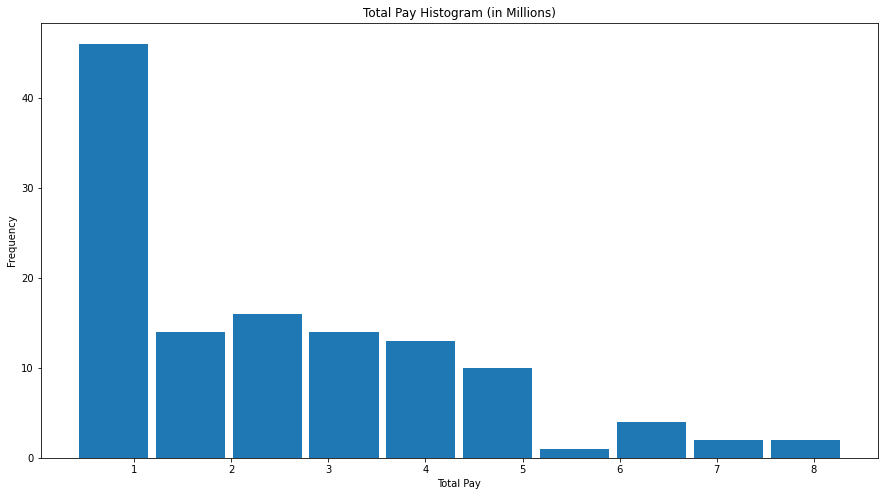

In [ ]:
plt.hist(e['TotalPay']/1000000,density=False, stacked=False, rwidth=0.9);
plt.title("Total Pay Histogram (in Millions)");
plt.xlabel("Total Pay");
plt.ylabel("Frequency");
plt.show();

Looking for significant outliers - could have tried to remove outliers in Big Ten, but opted not to for the first pass.   

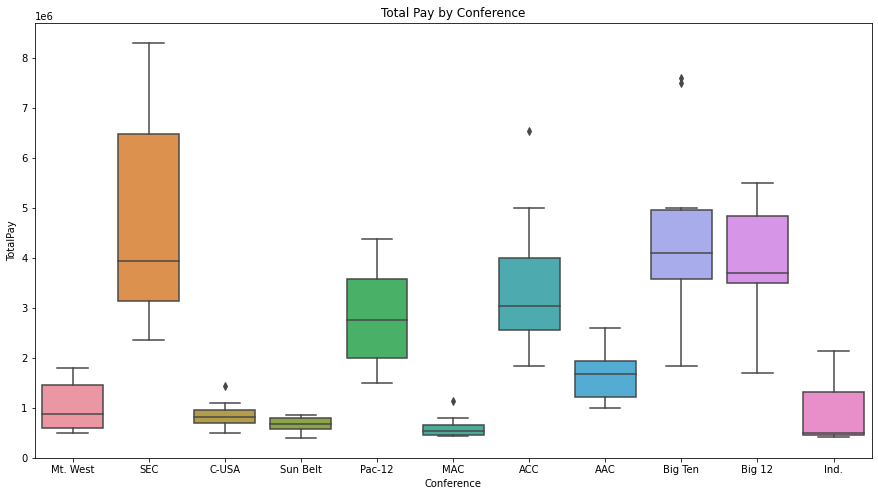

In [ ]:
# Set graph size:
plt.rcParams["figure.figsize"]=15,8

sns.boxplot(x='Conference', y='TotalPay', data=e)
plt.title('Total Pay by Conference')
plt.show();

Visualize pairplot

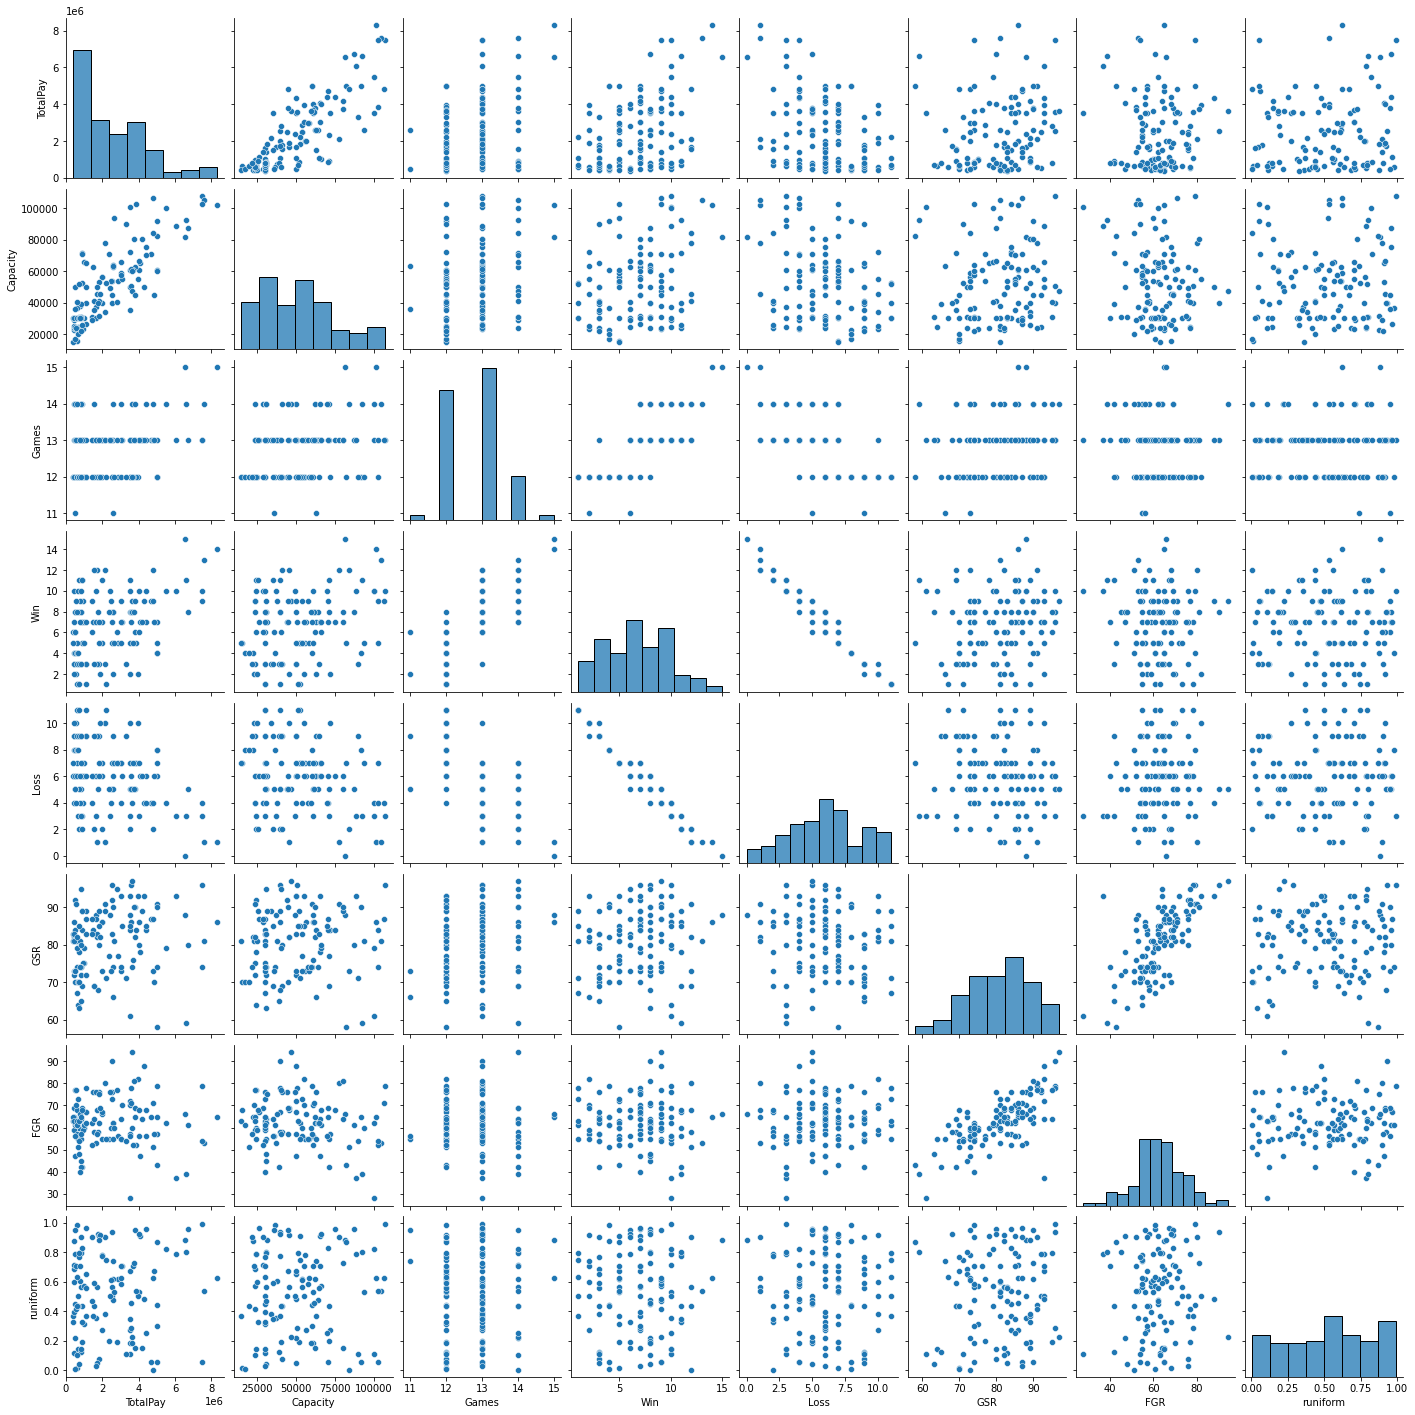

In [ ]:
#create pairs plot for all numeric variables
sns.pairplot(e)
plt.show();

Selecting **Total Pay** for comprehensive compensation

## Show Total Pay by Conference

# MODEL

Create training & test sets

In [ ]:
e.reset_index()

#-Set random seed so we're always using the same data
np.random.seed(1234)

#-add column with random uniform number identifier 
e['runiform']=uniform.rvs(loc=0, scale=1, size=len(e))

#-split into training & test models, first time
e_train = e[e['runiform']>=0.33] # Take 2/3 of data for training the model
e_test = e[e['runiform']<=0.33]  # Take 1/3 of data for testing the model

#-split into training & test models, second time
f_train = e[e['runiform']>=0.33] # Take 2/3 of data for training the model
f_test = e[e['runiform']<=0.33]  # Take 1/3 of data for testing the model

#-split into training & test models, second time
g_train = e[e['runiform']>=0.33] # Take 2/3 of data for training the model
g_test = e[e['runiform']<=0.33]  # Take 1/3 of data for testing the model

#-Check train & test counts
print("e_train rows: ", len(e_train))
print("e_test rows:", len(e_test))

#-Check train & test counts
print("f_train rows: ", len(f_train))
print("f_test rows:", len(f_test))

#-Check train & test counts
print("g_train rows: ", len(g_train))
print("g_test rows:", len(g_test))


,index,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR
0,0,Air Force,Mt. West,Troy Calhoun,885000.00,Falcon Stadium,52237.00,12.00,5.00,7.00,CO,89.00,nan
1,2,Alabama,SEC,Nick Saban,8307000.00,Bryant Denny Stadium,101821.00,15.00,14.00,1.00,AL,86.00,65.00
2,3,Alabama at Birmingham,C-USA,Bill Clark,900000.00,Legion Field,71594.00,14.00,11.00,3.00,AL,69.00,42.00
3,4,Appalachian State,Sun Belt,Scott Satterfield,712500.00,Kidd Brewer Stadium,24150.00,13.00,11.00,2.00,NC,78.00,60.00
4,5,Arizona,Pac-12,Kevin Sumlin,2000000.00,Arizona Stadium,56037.00,12.00,5.00,7.00,AZ,73.00,55.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,123,West Virginia,Big 12,Dana Holgorsen,3617500.00,Mountaineer Field,60000.00,12.00,8.00,4.00,WV,74.00,60.00
118,124,Western Kentucky,C-USA,Mike Sanford Jr.,805850.00,LT Smith Stadium,22113.00,12.00,3.00,9.00,KY,74.00,57.00
119,125,Western Michigan,MAC,Tim Lester,800000.00,Waldo Stadium,30200.00,13.00,7.00,6.00,MI,74.00,40.00
120,126,Wisconsin,Big Ten,Paul Chryst,3750000.00,Camp Randall Stadium,80321.00,13.00,8.00,5.00,WI,90.00,81.00


e_train rows:  88
e_test rows: 34
f_train rows:  88
f_test rows: 34
g_train rows:  88
g_test rows: 34


### Model 1
Create first model

In [ ]:
e.head(2)

,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,runiform
0,Air Force,Mt. West,Troy Calhoun,885000.00,Falcon Stadium,52237.00,12.00,5.00,7.00,CO,89.00,nan,0.19
2,Alabama,SEC,Nick Saban,8307000.00,Bryant Denny Stadium,101821.00,15.00,14.00,1.00,AL,86.00,65.00,0.62


In [ ]:
model1 = str('TotalPay ~ Conference + Capacity + Win + GSR')

Fit the model

In [ ]:
train_model_fit = smf.ols(model1, data=e_train).fit()

Show fit results

In [ ]:
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     26.06
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.94e-22
Time:                        18:31:29   Log-Likelihood:                -1322.3
No. Observations:                  88   AIC:                             2673.
Df Residuals:                      74   BIC:                             2707.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.20

Assign Predicted Values from the model fit to the training set

In [ ]:
e_train['prediction'] = train_model_fit.fittedvalues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Assign predicted values to the test set

In [ ]:
e_test['prediction'] = train_model_fit.predict(e_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
e_train.head(2)

,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,runiform,prediction
2,Alabama,SEC,Nick Saban,8307000.00,Bryant Denny Stadium,101821.00,15.00,14.00,1.00,AL,86.00,65.00,0.62,6469274.60
3,Alabama at Birmingham,C-USA,Bill Clark,900000.00,Legion Field,71594.00,14.00,11.00,3.00,AL,69.00,42.00,0.44,2418057.24


In [ ]:
e_test.head(2)

,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,runiform,prediction
0,Air Force,Mt. West,Troy Calhoun,885000.00,Falcon Stadium,52237.00,12.00,5.00,7.00,CO,89.00,nan,0.19,1282191.37
6,Arizona State,Pac-12,Herm Edwards,2000000.00,Sun Devil Stadium,56232.00,13.00,7.00,6.00,AZ,86.00,66.00,0.27,2859018.34


Compute proportion of response variance accounted for when predicting out of sample

In [ ]:
print('\nProportion of Test Set Variance Accounted for: ',\
    (round(np.power(e_test['TotalPay'].corr(e_test['prediction']),2),3)))


Proportion of Test Set Variance Accounted for:  0.778


Compute the increase in Total Pay based on Wins using the full model

In [ ]:
my_model_fit1 = smf.ols(model1, data=e).fit()

print(my_model_fit1.summary())

print("\nEstimated effect of Wins on TotalPay:", round(my_model_fit1.params[12],0))

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     35.42
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           5.85e-33
Time:                        18:31:29   Log-Likelihood:                -1834.5
No. Observations:                 122   AIC:                             3697.
Df Residuals:                     108   BIC:                             3736.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -9.64

In [ ]:
e.head(2)

,School,Conference,Coach,TotalPay,Stadium,Capacity,Games,Win,Loss,State,GSR,FGR,runiform
0,Air Force,Mt. West,Troy Calhoun,885000.00,Falcon Stadium,52237.00,12.00,5.00,7.00,CO,89.00,nan,0.19
2,Alabama,SEC,Nick Saban,8307000.00,Bryant Denny Stadium,101821.00,15.00,14.00,1.00,AL,86.00,65.00,0.62


In [ ]:
# sns.lmplot(x="Capacity", y="TotalPay", data=e);
print('R2 Capacity = ', stats.pearsonr(e['Capacity'], e['TotalPay'])[0] ** 2)
print('R2 Games = ', stats.pearsonr(e['Games'], e['TotalPay'])[0] ** 2)
print('R2 Wins = ', stats.pearsonr(e['Win'], e['TotalPay'])[0] ** 2)
print('R2 Losses = ', stats.pearsonr(e['Loss'], e['TotalPay'])[0] ** 2)
print('R2 GSR = ', stats.pearsonr(e['GSR'], e['TotalPay'])[0] ** 2)
#print('R2 FGR = ', stats.pearsonr(e['FGR'], e['TotalPay'])[0] ** 2)

R2 Capacity =  0.6589551028370952
R2 Games =  0.12876282945358078
R2 Wins =  0.1518154708365577
R2 Losses =  0.1351605153873213
R2 GSR =  0.030779713212330702


## Model 2

In [ ]:
model2 = str('TotalPay ~ Conference + Capacity + Win')

In [ ]:
train_model_fit2 = smf.ols(model2, data=f_train).fit()

In [ ]:
print(train_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     28.42
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           4.33e-23
Time:                        18:31:29   Log-Likelihood:                -1322.5
No. Observations:                  88   AIC:                             2671.
Df Residuals:                      75   BIC:                             2703.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.97

In [ ]:
f_train['prediction'] = train_model_fit2.fittedvalues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
f_test['prediction'] = train_model_fit2.predict(f_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print('\nProportion of Test Set Variance Accounted for in model 2: ',\
    (round(np.power(f_test['TotalPay'].corr(f_test['prediction']),2),3)))


Proportion of Test Set Variance Accounted for in model 2:  0.778


In [ ]:
my_model_fit2 = smf.ols(model2, data=e).fit()

print(my_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     38.58
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.08e-33
Time:                        18:31:29   Log-Likelihood:                -1834.7
No. Observations:                 122   AIC:                             3695.
Df Residuals:                     109   BIC:                             3732.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -4.97

# INTERPRET
## LAB 1 QUESTIONS
Model 2 was identified as the best model and is used for all analysis where GSR (Graduate Student Rate) is not required. For those questions Model 1 is used. 

**1. What is the recommended salary for the Syracuse football coach?**

In [ ]:
df_new = e_train.query("School=='Syracuse'")
currency = "${:,.2f}".format(df_new['prediction'].iloc[0])
print('    The recommended salary for the Syracuse football coach under Model 1 is ', currency)

df_new = f_train.query("School=='Syracuse'")
currency = "${:,.2f}".format(df_new['prediction'].iloc[0])
print('    The recommended salary for the Syracuse football coach under Model 2 is ', currency)

    The recommended salary for the Syracuse football coach under Model 1 is  $3,535,792.36
    The recommended salary for the Syracuse football coach under Model 2 is  $3,515,671.66


               
    The recommended salary for the Syracuse football coach would be **~3.5 Million**.

**2. What would his salary be if we were still in the Big East? What if we went to the Big Ten?**

    Given that Big East = AAC, then 

    Big East = ~3.5 Million  
    Big Ten = ~3.9 Million

**3. What schools did we drop from our data and why?**

    * Liberty - no stadium data
    * Akron - no graduation data
    * Army - no graduation data

**4. What effect does graduation rate have on the projected Total Pay?**   

1.   List item
2.   List item

Given that GSR = Graduation Success Rate, it has very little impact on Total Pay and is an unreliable predictoras shown by the p-value of over 0.50. **The estimated effect of GSR on TotalPay from model 1 is $5,716**

In [ ]:
print("\n    Estimated effect of GSR on TotalPay from model 1:", round(my_model_fit1.params[13],0))


    Estimated effect of GSR on TotalPay from model 1: 5716.0


**5. How good is our model?**

* Model 2 has the lower AIC score, eliminating the GSR variable and chosen as the best fit.
* R2 = 0.809
* Adjusted R2 = 0.788
* p-value significant at the alpha = 0.05 level, &/or 0.025 - 0.975 range DOES NOT CROSS 0 for the following variables, indicating they are significant predictors:
  - AAC Conference
  - Big 12 Conference
  - Big 10 Conference
  - SEC Conference
  - Capacity
  - Wins
* The overall p-value for Model 2 of 1.08e-33, combined with the adjusted square of 0.791 indicates this a good model.  

In [ ]:
print('\nProportion of Test Set Variance Accounted for: ',\
    (round(np.power(f_test['TotalPay'].corr(f_test['prediction']),2),3)))


Proportion of Test Set Variance Accounted for:  0.778


**6. What is the single biggest impact on salary size?**

* A Conference of SEC has the biggest impact on salary size. It has a coefficient of 1,735,000 indicating being in the SEC increases predicted salary by stated amount. After conferences, the biggest impact on salary size is number of wins. For each win a coach's salary is estimated to increase by $117,000.